# Comparing wasm exported Datasets with Rust natives

In this notebook, we compare the performances of wasm exported and rust natives datasets.

The studied datasets are Sophia FastDataset, Sophia LightDataset, our own FullDataset (a data structure that uses HashMap of every possible key parts to the whole dataset) and our own TreeDataset (a data structure that can index every possible quad order, and store them using trees)

## Loading data

In [1]:
# import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [2]:
dataset_types = [("Fast", ""), ("Full", "_full"), ("Tree", "_tree"), ("Light", "_lg")]
prefixes = "matchforeach/"
queries = ["query", "query3", "query2", "query4"]
extension = ".csv"

In [3]:
import csv

## Compute average

In [4]:
data = {}

for target in [("Rust", ""), ("Wasm", "_js")]:
    for query in queries:
        for dataset_type in dataset_types:
            filename = prefixes + query + "-sophia" + target[1] + dataset_type[1] + extension

            with open(filename, 'r') as file:
                reader = csv.reader(file)
                is_first = True
                for row in reader:
                    if is_first:
                        is_first = False
                    else:
                        total_time = float(row[7]) + float(row[8])
                        key = (query, dataset_type[0], int(row[1]), target[0])
                        
                        if key not in data:
                            data[key] = []
                        
                        data[key].append(total_time)

                 
def avg(l):
    i = 0
    for x in l:
        i += x
    return i / len(l)
    
    
for key in data:
    data[key] = avg(data[key])

In [5]:
def draw_plot(query_name, graph_name):
    for target in ['Rust', 'Wasm']:
        x = []
        y = []
        
        for entry in data:
            if entry[0] == query_name and entry[1] == graph_name and entry[3] == target:
                x.append(entry[2])
                y.append(data[entry])
                
        qname = query_name
        if qname == "query":
            qname = "query1"
        
        plt.title("Comparing " + graph_name + " Dataset on " + qname)
        
        plt.loglog(x, y)
        
    plt.show()

## Plot drawing

We draw a plot for every dataset and query to compare the plot shape

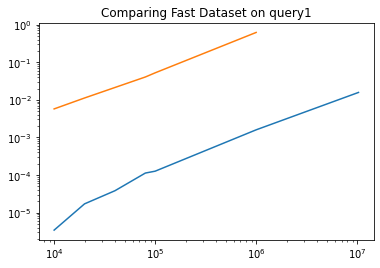

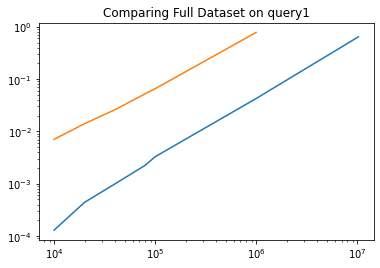

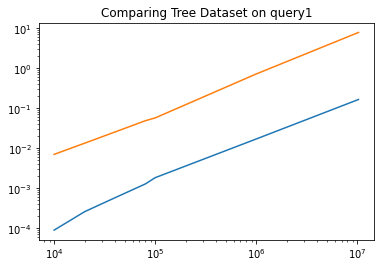

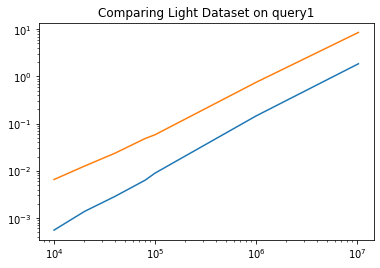

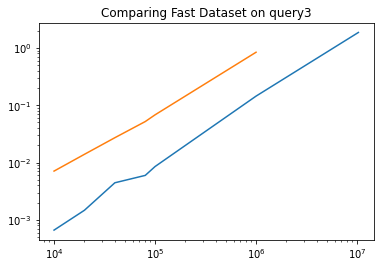

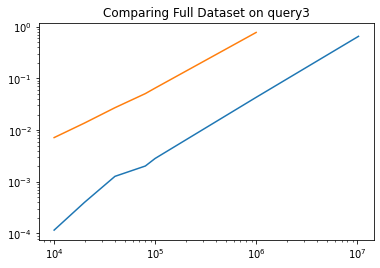

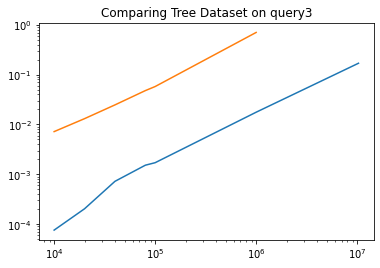

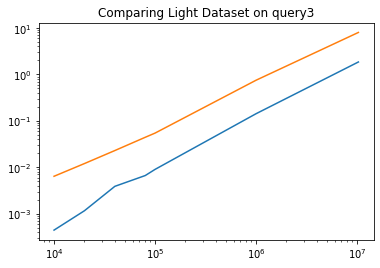

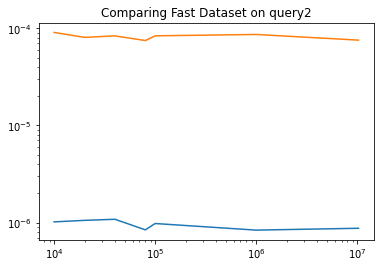

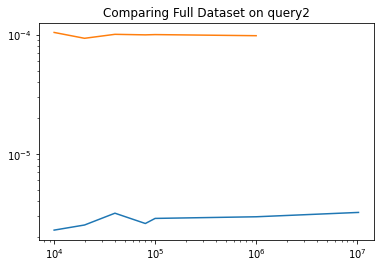

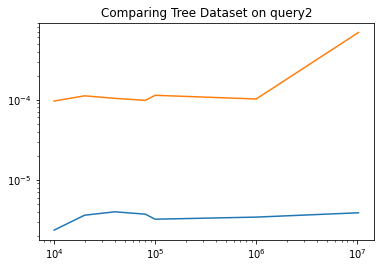

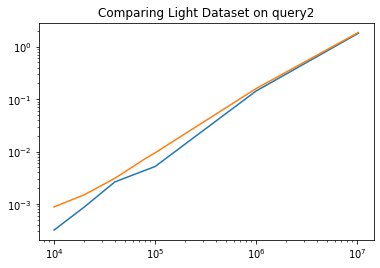

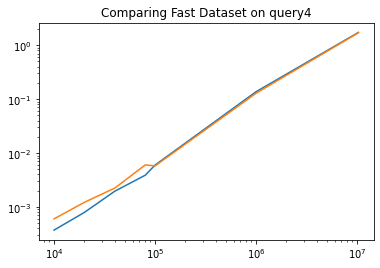

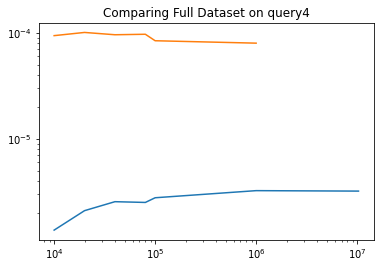

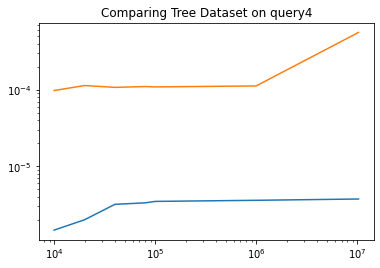

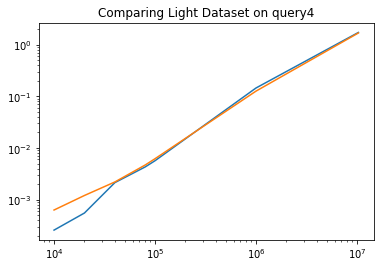

In [6]:
for query in queries:
    for dataset_type in dataset_types:
        draw_plot(query, dataset_type[0])